In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [35]:
# import libraries and packages 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, plot_confusion_matrix

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("../input/credit-risk-dataset/credit_risk_data.csv")

In [4]:
# display total non-null records and column type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   sex                         32581 non-null  object 
 2   education                   32581 non-null  object 
 3   married                     32581 non-null  int64  
 4   person_income               32581 non-null  int64  
 5   person_home_ownership       32581 non-null  object 
 6   has_car                     32581 non-null  int64  
 7   person_emp_length           31686 non-null  float64
 8   loan_intent                 32581 non-null  object 
 9   loan_grade                  32581 non-null  object 
 10  loan_amnt                   32581 non-null  int64  
 11  loan_int_rate               29465 non-null  float64
 12  itd                         29465 non-null  float64
 13  term                        325

In [5]:
# display some stats value of numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.000000,23.000000,26.000000,30.000000,1.440000e+02
married,32581.0,0.501796,0.500004,0.000000,0.000000,1.000000,1.000000,1.000000e+00
person_income,32581.0,66074.848470,61983.119168,4000.000000,38500.000000,55000.000000,79200.000000,6.000000e+06
has_car,32581.0,0.622571,0.484751,0.000000,0.000000,1.000000,1.000000,1.000000e+00
person_emp_length,31686.0,4.789686,4.142630,0.000000,2.000000,4.000000,7.000000,1.230000e+02
loan_amnt,32581.0,9589.371106,6322.086646,500.000000,5000.000000,8000.000000,12200.000000,3.500000e+04
loan_int_rate,29465.0,11.011695,3.240459,5.420000,7.900000,10.990000,13.470000,2.322000e+01
itd,29465.0,30.915624,41.486178,3.293056,13.068411,20.923326,35.745345,3.193471e+03
loan_percent_income,32581.0,0.170203,0.106782,0.000000,0.090000,0.150000,0.230000,8.300000e-01
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.000000,3.000000,4.000000,8.000000,3.000000e+01


<AxesSubplot:>

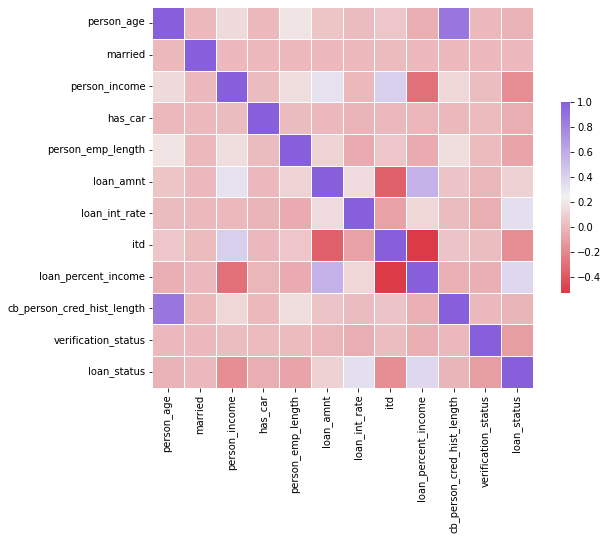

In [58]:
corr = df.corr(method = 'pearson')
f, ax = plt.subplots(figsize=(10, 7))
cmap = sns.diverging_palette(10, 275, as_cmap=True)

sns.heatmap(corr, cmap=cmap, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.5}, ax=ax)

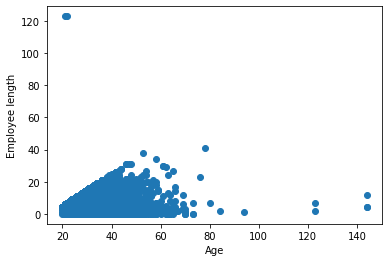

<Figure size 960x800 with 0 Axes>

In [6]:
plt.scatter("person_age", 'person_emp_length', data=df)
plt.xlabel('Age')
plt.ylabel('Employee length')
plt.figure(figsize=(12, 10), dpi=80)
plt.show()

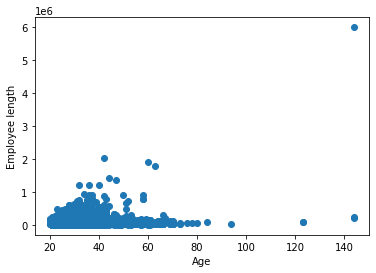

<Figure size 960x800 with 0 Axes>

In [7]:
plt.scatter("person_age", 'person_income', data=df)
plt.xlabel('Age')
plt.ylabel('Employee length')
plt.figure(figsize=(12, 10), dpi=80)
plt.show()

In [8]:
# Remove outlier on original and version 2 (add more attribute) dataset
df = df[df["person_age"] < 80]
df = df[df["person_income"] < 3000000]
df = df[(df["person_emp_length"] < 100) | (df["person_emp_length"].isnull())]
df.shape

(32571, 19)

In [9]:
# reset index in dataframe for running algorithm
df.reset_index(drop=True, inplace=True)

In [10]:
# split data to features and labels
features = df.drop(columns=["loan_status"], axis=1)
labels = df["loan_status"]

<BarContainer object of 2 artists>

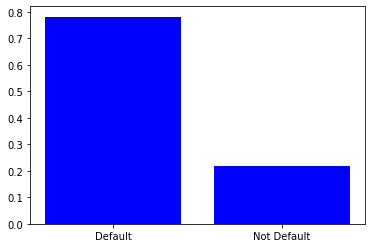

In [11]:
label_dist = list(labels.value_counts() / len(labels))
plt.bar(["Default", "Not Default"], label_dist, color="blue")

In [12]:
categorical = list(features.select_dtypes(include="object"))
numerical = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'itd']
binary = ["has_car", "married", "verification_status"]

In [13]:
# Pipeline
categorical_pipe = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown='ignore', sparse=False))
])

numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

numerical_scaler_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer([
    ("cat", categorical_pipe , categorical),
    ("num", numerical_pipeline, numerical)
])

preprocessor_with_scaler = ColumnTransformer([
    ("cat", categorical_pipe , categorical),
    ("num", numerical_scaler_pipe, numerical)
])

In [43]:
def testing(model, x, y):
    y_pred = model.predict(x)
    precision = precision_score(y, y_pred, average=None)
    recall = recall_score(y, y_pred, average=None)
    f1 = f1_score(y, y_pred, average=None)
    print(classification_report(y, y_pred))
    return {"precision": precision, "recall": recall, "f1": f1}

In [15]:
# Split train data and test data
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [16]:
y_test.value_counts()

0    5081
1    1434
Name: loan_status, dtype: int64

In [17]:
# KNN Algorithm
KNN_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", KNeighborsClassifier()),
])

param = {
    'model__n_neighbors' : [50, 75, 100, 125, 150],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2, 3]
}
gridsearch_knn = GridSearchCV(estimator = KNN_pipeline, # algorithm using
                        param_grid = param, # param for search best parameters
                        scoring = 'f1', # metric for kfold validation and choose best estimator
                        cv = 5,  # num fold using in kfold validation
                        verbose = 1, # print complete training with gridsearch
                        n_jobs = -1) # using all cpu core.

In [18]:
gridsearch_knn.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['sex',
                                                                          'education',
                                                                          'person_home_ownership',
                                                                          'loan_intent',
                                                                          'loan_grade',
                                                

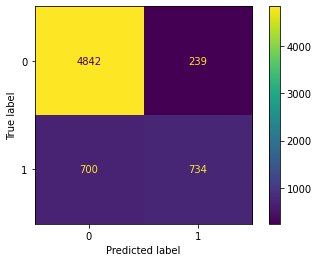

In [42]:
plot_confusion_matrix(gridsearch_knn, x_test, y_test)

In [44]:
print(gridsearch_knn.best_estimator_["model"])
print("Best f1 score for v1 data:", gridsearch_knn.best_score_)
knn_scores = testing(gridsearch_knn, x_test, y_test)

KNeighborsClassifier(n_neighbors=50, p=1, weights='distance')
Best f1 score for v1 data: 0.5979465496775642
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5081
           1       0.75      0.51      0.61      1434

    accuracy                           0.86      6515
   macro avg       0.81      0.73      0.76      6515
weighted avg       0.85      0.86      0.85      6515



In [21]:
# Logistic Regression
log_reg_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor_with_scaler),
    ("model", LogisticRegression(class_weight="balanced", tol=1e-5)),
])

param = {
    'model__C': [0.01, 0.1, 1, 10, 50, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}

gridsearch_log_reg = GridSearchCV(estimator = log_reg_pipeline, # algorithm using
                        param_grid = param, # param for search best parameters
                        scoring = 'f1', # metric for kfold validation and choose best estimator
                        cv = 5,  # num fold using in kfold validation
                        verbose = 1, # print complete training with gridsearch
                        n_jobs = -1) # using all cpu core.

In [22]:
gridsearch_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['sex',
                                                                          'education',
                                                                          'person_home_ownership',
                                                                          'loan_intent',
                                                                          'loan_grade',
                                                

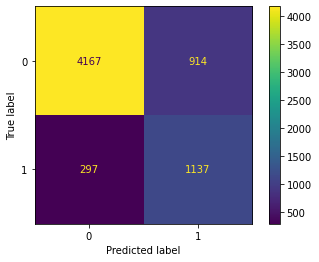

In [45]:
plot_confusion_matrix(gridsearch_log_reg, x_test, y_test)

In [46]:
print(gridsearch_log_reg.best_estimator_["model"])
print("Best f1 score for data:", gridsearch_log_reg.best_score_)
log_reg_scores = testing(gridsearch_log_reg, x_test, y_test)

LogisticRegression(C=10, class_weight='balanced', solver='liblinear', tol=1e-05)
Best f1 score for data: 0.6438952202372998
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      5081
           1       0.55      0.79      0.65      1434

    accuracy                           0.81      6515
   macro avg       0.74      0.81      0.76      6515
weighted avg       0.85      0.81      0.82      6515



In [24]:
pipeline_svm = Pipeline([
    ("preprocessor", preprocessor_with_scaler),
    ("model", SVC(class_weight="balanced")),
])

param = [
    {"model__kernel": ["rbf"], "model__gamma": [0.01, 0.1, 1, 10, 100], "model__C": [0.01, 0.1, 1, 10, 100]},
    {"model__kernel": ["linear"], "model__C": [0.01, 0.1, 1, 10, 100]},
    {"model__kernel": ["poly"], "model__C": [0.01, 0.1, 1, 10, 100], "model__degree": [2, 3, 4]}
]

gridsearch_svm = GridSearchCV(estimator = pipeline_svm, # algorithm using
                        param_grid = param, # param for search best parameters
                        scoring = 'f1', # metric for kfold validation and choose best estimator
                        cv = 5,  # num fold using in kfold validation
                        verbose = 1, # print complete training with gridsearch
                        n_jobs = -1) # using all cpu core.

In [25]:
gridsearch_svm.fit(x_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 106.8min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 129.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['sex',
                                                                          'education',
                                                                          'person_home_ownership',
                                                                          'loan_intent',
                                                                          'loan_grade',
                                                 

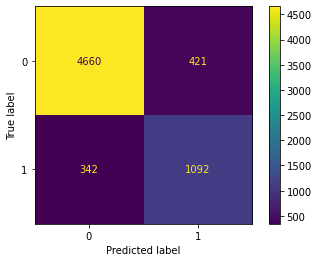

In [47]:
plot_confusion_matrix(gridsearch_svm, x_test, y_test)

In [51]:
print(gridsearch_svm.best_estimator_["model"])
print("Best f1 score for data:", gridsearch_svm.best_score_)
svm_scores = testing(gridsearch_svm, x_test, y_test)

SVC(C=1, class_weight='balanced', degree=4, kernel='poly')
Best f1 score for data: 0.7337544006222846
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      5081
           1       0.72      0.76      0.74      1434

    accuracy                           0.88      6515
   macro avg       0.83      0.84      0.83      6515
weighted avg       0.89      0.88      0.88      6515



In [27]:
pipeline_randomforest = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(class_weight="balanced")),
])

param = {
    "model__bootstrap": [True, False],
    'model__max_depth': [15, 25, 35, None],
    'model__max_features': [None, "sqrt"],
    'model__n_estimators': [50, 100, 150],
    "model__criterion": ["gini", "entropy"]
}
gridsearch_randomforest = GridSearchCV(estimator = pipeline_randomforest, # algorithm using
                        param_grid = param, # param for search best parameters
                        scoring = 'f1', # metric for kfold validation and choose best estimator
                        cv = 5,  # num fold using in kfold validation
                        verbose = 1, # print complete training with gridsearch
                        n_jobs = -1) # using all cpu core.

In [28]:
gridsearch_randomforest.fit(x_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 33.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['sex',
                                                                          'education',
                                                                          'person_home_ownership',
                                                                          'loan_intent',
                                                                          'loan_grade',
                                                 

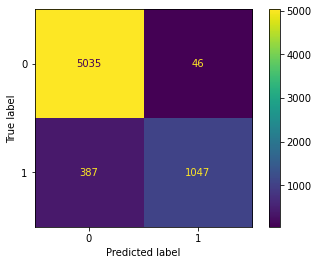

In [48]:
plot_confusion_matrix(gridsearch_randomforest, x_test, y_test)

In [33]:
print(gridsearch_randomforest.best_estimator_["model"])
print("Best f1 score for data:", gridsearch_randomforest.best_score_)
randomforest_scores = testing(gridsearch_randomforest, x_test, y_test)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, max_features=None, n_estimators=50)
Best f1 score for data: 0.816415081445489
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5081
           1       0.96      0.73      0.83      1434

    accuracy                           0.93      6515
   macro avg       0.94      0.86      0.89      6515
weighted avg       0.94      0.93      0.93      6515



In [36]:
pipeline_adaboost = Pipeline([
    ("preprocessor", preprocessor),
    ("model", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight="balanced"))),
])

param = {
    "model__n_estimators": [75, 100, 125, 150],
    "model__base_estimator__max_depth": [1, 2, 3, 4, 5, 6],
    "model__base_estimator__criterion": ["gini", "entropy"]
}


gridsearch_adaboost = GridSearchCV(estimator = pipeline_adaboost, # algorithm using
                        param_grid = param, # param for search best parameters
                        scoring = 'f1', # metric for kfold validation and choose best estimator
                        cv = 5,  # num fold using in kfold validation
                        verbose = 1, # print complete training with gridsearch
                        n_jobs = -1) # using all cpu core.

In [38]:
gridsearch_adaboost.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 13.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['sex',
                                                                          'education',
                                                                          'person_home_ownership',
                                                                          'loan_intent',
                                                                          'loan_grade',
                                                 

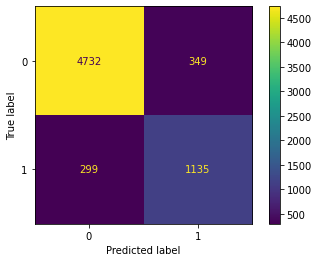

In [49]:
plot_confusion_matrix(gridsearch_adaboost, x_test, y_test)

In [41]:
print(gridsearch_adaboost.best_estimator_["model"])
print("Best f1 score for data:", gridsearch_adaboost.best_score_)
adaboost_scores = testing(gridsearch_adaboost, x_test, y_test)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=4),
                   n_estimators=150)
Best f1 score for data: 0.7721260237736274
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      5081
           1       0.76      0.79      0.78      1434

    accuracy                           0.90      6515
   macro avg       0.85      0.86      0.86      6515
weighted avg       0.90      0.90      0.90      6515



In [52]:
model_names = ['KNN', 'LogReg', 'SVM', 'RF', 'Ada']
list_scores = [knn_scores, log_reg_scores, svm_scores, randomforest_scores, adaboost_scores]
avg_precision = [np.mean(x["precision"]) for x in list_scores]
avg_recall = [np.mean(x["recall"]) for x in list_scores]
avg_f1 = [np.mean(x["f1"]) for x in list_scores]

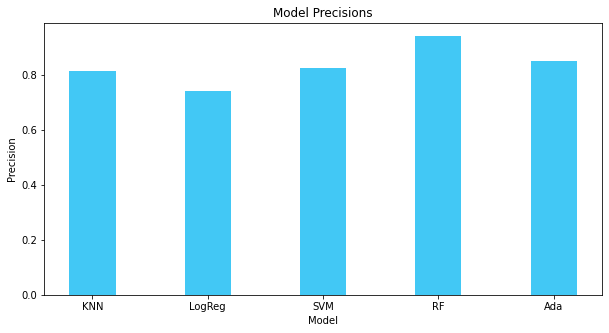

In [55]:
fig = plt.figure(figsize = (10, 5))
plt.bar(model_names, avg_precision, color ='#42c8f5', width = 0.4)
plt.xlabel("Model")
plt.ylabel("Precision")
plt.title("Model Precisions")
plt.show()

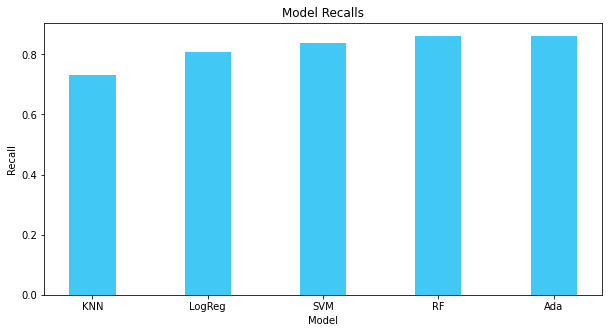

In [56]:
fig = plt.figure(figsize = (10, 5))
plt.bar(model_names, avg_recall, color ='#42c8f5', width = 0.4)
plt.xlabel("Model")
plt.ylabel("Recall")
plt.title("Model Recalls")
plt.show()

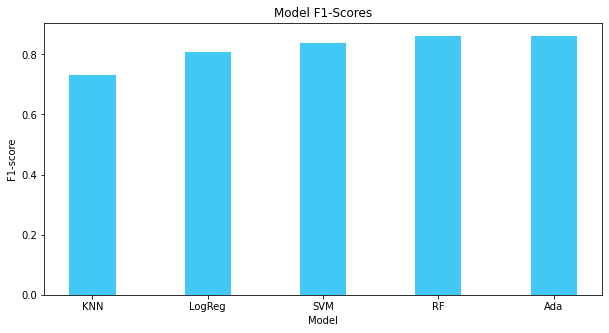

In [57]:
fig = plt.figure(figsize = (10, 5))
plt.bar(model_names, avg_recall, color ='#42c8f5', width = 0.4)
plt.xlabel("Model")
plt.ylabel("F1-score")
plt.title("Model F1-Scores")
plt.show()